# Section 1: Data Import and Preparation
This section imports the necessary libraries and reads data from the specified files. The data has been sourced as a snapshot from Refinitiv and is up-to-date as of July 13, 2024. The data is processed to calculate the mid rates.

In [14]:
# Import necessary libraries
import pandas as pd
import numpy as np
import QuantLib as ql
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import PercentFormatter
from datetime import datetime

# Input file paths
ois_file_path = 'Dati/EURESTOIS=.xlsm'
forwards_ois_ecb_file_path = 'Dati/EUESTECBF=ICAP.xlsm'
deposit_file_path = 'Dati/EURDEPO=.xlsm'
fra3M_file_path = 'Dati/EUR3MFRA=.xlsm'
fra6M_file_path = 'Dati/6M/EUR6MFRA=.xlsm'
swap3M_file_path = 'Dati/EURAB3EIRS=.xlsm'
swap6M_file_path = 'Dati/6M/EURAB6EIRS=.xlsm'
futures3M_file_path = 'Dati/FUTURE3M.xlsm'

# ECB maintenance periods
ecb_maintenance_periods = {
    "JAN24": {"start": ql.Date(31, ql.January, 2024), "end": ql.Date(12, ql.March, 2024)},
    "MAR24": {"start": ql.Date(13, ql.March, 2024), "end": ql.Date(16, ql.April, 2024)},
    "APR24": {"start": ql.Date(17, ql.April, 2024), "end": ql.Date(11, ql.June, 2024)},
    "JUN24": {"start": ql.Date(12, ql.June, 2024), "end": ql.Date(23, ql.July, 2024)},
    "JUL24": {"start": ql.Date(24, ql.July, 2024), "end": ql.Date(17, ql.September, 2024)},
    "SEP24": {"start": ql.Date(18, ql.September, 2024), "end": ql.Date(22, ql.October, 2024)},
    "OCT24": {"start": ql.Date(23, ql.October, 2024), "end": ql.Date(17, ql.December, 2024)},
    "DEC24": {"start": ql.Date(18, ql.December, 2024), "end": "tbd"}
}

# Function to read data and calculate average rates
def load_and_process_data(file_path, sheet_name):
    data = pd.read_excel(file_path, sheet_name=sheet_name, engine='openpyxl')
    data['Mid_Rate'] = (data['Bid'] + data['Ask']) / 2
    return data

# Load and process data
ois_data = load_and_process_data(ois_file_path, 'Sheet1')
forwards_ois_ecb_data = load_and_process_data(forwards_ois_ecb_file_path, 'Sheet1')
deposit_data = load_and_process_data(deposit_file_path, 'Sheet1')
fra_data3M = load_and_process_data(fra3M_file_path, 'Sheet1')
fra_data3M_0x3_rate = pd.DataFrame({'Maturity':['0X3','1X4'], 'Bid':[3.654,3.579],'Ask':[3.674,3.599]}) # 12/07/2024 0x3 rate, different contributor than the other fra rates
fra_data3M_0x3_rate['Mid_Rate'] = (fra_data3M_0x3_rate['Bid'] + fra_data3M_0x3_rate['Ask']) / 2
fra_data6M = load_and_process_data(fra6M_file_path, 'Sheet1')
fra_data6M_0x6_rate = pd.DataFrame({'Maturity':['0X6'], 'Bid':[3.652],'Ask':[3.672]}) # 12/07/2024 0x6 rate, different contributor than the other fra rates
fra_data6M_0x6_rate['Mid_Rate'] = (fra_data6M_0x6_rate['Bid'] + fra_data6M_0x6_rate['Ask']) / 2
swap_data3M = load_and_process_data(swap3M_file_path, 'Sheet1')
swap_data6M = load_and_process_data(swap6M_file_path, 'Sheet1')
futures_data3M = load_and_process_data(futures3M_file_path, 'Sheet1')

# Merge fra 3M and 6M data
fra_data3M = pd.concat([fra_data3M_0x3_rate, fra_data3M], ignore_index=True)
fra_data6M = pd.concat([fra_data6M_0x6_rate, fra_data6M], ignore_index=True)

# Section 2: Convert Maturities and Set Evaluation Date
This section defines functions to convert maturity strings into QuantLib periods and processes the dataset to include these periods. It also sets up necessary adjustments for ECB maintenance periods and futures maturities, and defines specific maturities based on the Ametrano and Bianchetti study. The evaluation date for all calculations is set at the end.

In [15]:
# Map to convert calendar units to QuantLib periods
period_map = {
    "D": ql.Days,
    "W": ql.Weeks,
    "M": ql.Months,
    "Y": ql.Years
}

# Map for fixing days
fixing_days_map = {
    "ON": 0,
    "TN": 1,
    "SN": 2,
    "SW": 2,
    "2W": 2,
    "3W": 2
}

# Function to convert maturities to QuantLib periods, handling special cases
def convert_to_period(maturity):
    special_maturity_format = {
        "ON": ql.Period(1, ql.Days),
        "TN": ql.Period(2, ql.Days),
        "SN": ql.Period(3, ql.Days),
        "SW": ql.Period(1, ql.Weeks)
    }
    
    if maturity in special_maturity_format:
        return special_maturity_format[maturity]
    
    try:
        if 'X' in maturity:
            start, end = maturity.split('X')
            return ql.Period(int(start), ql.Months), ql.Period(int(end), ql.Months)
        num = int(maturity[:-1])
    except ValueError:
        raise ValueError(f"Invalid maturity format: {maturity}")
    
    unit = maturity[-1]
    return ql.Period(num, period_map[unit])

# Function to convert QuantLib dates to datetime for matplotlib
def _to_datetime(_date):
    return datetime(_date.year(), _date.month(), _date.dayOfMonth())

# Convert maturities to QuantLib periods
ois_data['Period'] = ois_data['Maturity'].apply(convert_to_period)
deposit_data['Period'] = deposit_data['Maturity'].apply(convert_to_period)
fra_data3M['Start_Period'], fra_data3M['End_Period'] = zip(*fra_data3M['Maturity'].apply(convert_to_period))
fra_data6M['Start_Period'], fra_data6M['End_Period'] = zip(*fra_data6M['Maturity'].apply(convert_to_period))
swap_data3M['Period'] = swap_data3M['Maturity'].apply(convert_to_period)
swap_data6M['Period'] = swap_data6M['Maturity'].apply(convert_to_period)

# Process forward OIS ECB data within maintenance periods
# Remove unused maintenance periods
del ecb_maintenance_periods["JAN24"]
del ecb_maintenance_periods["MAR24"]
del ecb_maintenance_periods["APR24"]
del ecb_maintenance_periods["JUN24"]
del ecb_maintenance_periods["DEC24"]

# Remove unused forward OIS ECB data
forwards_ois_ecb_data = forwards_ois_ecb_data[(forwards_ois_ecb_data.index > 0) & (forwards_ois_ecb_data.index < 4)]

# Set start and end dates for maintenance periods and forward OIS ECB maturities
period_keys = list(ecb_maintenance_periods.keys())
forwards_ois_ecb_data['Start_Period'] = [ecb_maintenance_periods[key]['start'] for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data['End_Period'] = [ecb_maintenance_periods[key]['end'] + 1 for key in period_keys[:len(forwards_ois_ecb_data)]]
forwards_ois_ecb_data.drop(columns=['Maturity'], inplace=True)

# Set IMM dates for Euribor futures maturities
def imm_date_corrected(data):
    month_str = data[:3]  # First three characters represent the month (e.g., 'JUL')
    year_str = data[3:]   # Remaining characters represent the year (e.g., '4')

    month = datetime.strptime(month_str, '%b').month
    year = 2020 + int(year_str)  # Corrected to handle years in 2020s
    
    # Calculate the next IMM date
    date = datetime(year, month, 1)
    return ql.IMM.nextDate(ql.Date(date.day, date.month, date.year))

futures_data3M['Start_Date'] = futures_data3M['Maturity'].apply(imm_date_corrected)
futures_data3M = futures_data3M[(futures_data3M.index > 4) & (futures_data3M.index < 11)]

# Define maturities based on Ametrano and Bianchetti study
ESTR_curve_deposit_maturities_chosen = ['ON', 'TN', 'SN'] 
fra3M_maturities_chosen = ['2X5','3X6', '4X7', '5X8', '6X9', '7X10', '8X11', '9X12','12X15','15X18', '16X19', '18X21','21X24']
fra_maturities_chosen = ['1X7', '2X8', '3X9', '4X10', '5X11', '6X12', '7X13', '8X14', '9X15', '10X16', '11X17', '12X18', '18X24']
swap_maturities_chosen = ['3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']
futures_maturities_chosen = ['DEC4', 'MAR5', 'JUN5', 'SEP5', 'DEC5', 'MAR6']

# DEBUG: Print data
DEBUG_DATI = False
if DEBUG_DATI:
    print(f"Deposit Data: {deposit_data}")
    print(f"OIS Data: {ois_data}")
    print(f"Forwards OIS ECB Data: {forwards_ois_ecb_data}")
    print(f"FRA Data: {fra_data3M}")
    print(f"Swap Data: {swap_data3M}")
    print(f"Futures Data: {futures_data3M}")

# Set the evaluation date for the curves
settle_date = ql.Date(12, 7, 2024)
ql.Settings.instance().evaluationDate = settle_date




# Section 3: Building the €STR Discount Curve
This section defines a function to build the €STR discount curve. It initializes the curve with selected deposits, OIS pre-ECB, forward OIS ECB, and OIS post-ECB data. The function also includes an option to visualize the resulting yield curve.

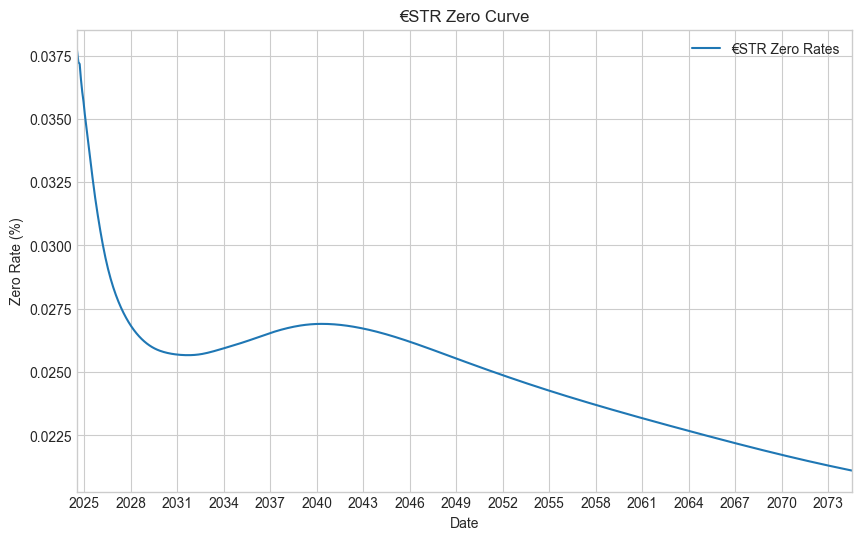

In [16]:
def estr_curve_builder(
    ois_data=ois_data,
    deposit_data=deposit_data,
    forwards_ois_ecb_data=forwards_ois_ecb_data,
    graph=True):
    
# Initialize an empty list to contain €STR curve helpers
    estr_helpers = []

    # Initialize the €STR curve
    estr = ql.Estr()

    # 1) Deposits
    # Add helpers for the first part of the curve from selected deposits
    selected_data = deposit_data[deposit_data['Maturity'].isin(ESTR_curve_deposit_maturities_chosen)]

    estr_helpers += [
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
            ql.Period(1, ql.Days),
            fixing_days_map[row['Maturity']],
            ql.TARGET(),
            ql.Following,
            False,
            ql.Actual360()
        )
        for _, row in selected_data.iterrows()
    ]

    # 2) OIS pre-ECB
    ois_pre_ecb = ois_data[ois_data.index < 1] # Watch for overlapping with forward OIS ECB
    # Add helpers for the second part of the curve from selected OIS pre-ECB
    estr_helpers += [
        ql.OISRateHelper(
            2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
        )
        for index, row in ois_pre_ecb.iterrows()
    ]

    # 3) Forward OIS ECB dates
    # Add helpers for the third part of the curve from selected Forward OIS ECB
    estr_helpers += [
        ql.DatedOISRateHelper(
            row['Start_Period'], row['End_Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
        )
        for index, row in forwards_ois_ecb_data.iterrows()
    ]

    # 4) OIS post-ECB
    ois_post_ecb = ois_data[ois_data.index > 7] # Watch for overlapping with forward OIS ECB
    estr_helpers += [
        ql.OISRateHelper(
            2, row['Period'], ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), estr
        )
        for index, row in ois_post_ecb.iterrows()
    ]

    # DEBUG: Print details of all helpers
    DEBUG_ESTR = False
    if DEBUG_ESTR:
        print("€STR Helpers:")
        for helper in estr_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the €STR discount curve
    estr_curve = ql.PiecewiseLogCubicDiscount(0, ql.TARGET(), estr_helpers, ql.Actual365Fixed())
    estr_curve.enableExtrapolation() # Enable extrapolation for dates beyond the available data

    # Calculate discount factors for specified dates
    dates = [settle_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]

    # Convert dates to datetime format
    dates_dt = [_to_datetime(date) for date in dates]
    estr_zero_rates = [
        estr_curve.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
        for date in dates
    ]

    # Create the €STR yield curve graph
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, estr_zero_rates, label='€STR Zero Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlim(dates_dt[0], dates_dt[-1])
        plt.xlabel('Date')
        plt.ylabel('Zero Rate (%)')
        plt.title('€STR Zero Curve')
        plt.legend()
        plt.grid(True)
        plt.show()

    return estr_curve, estr_helpers, estr_zero_rates

estr_curve, estr_helpers, estr_zero_rates = estr_curve_builder()


# Section 4: ECB Liquidity Check for Short-Term Rate Analysis
In this section, we streamline the analysis by using flat forward rates instead of log-cubic discounts, focusing on short-term rate changes over the first 12 months. We calculate the forward rates for the €STR using a PiecewiseFlatForward curve and plot them alongside the ECB forward rates. By analyzing the plotted curves and data points, we aim to detect any potential liquidity jumps that may occur due to ECB deadlines or market adjustments.

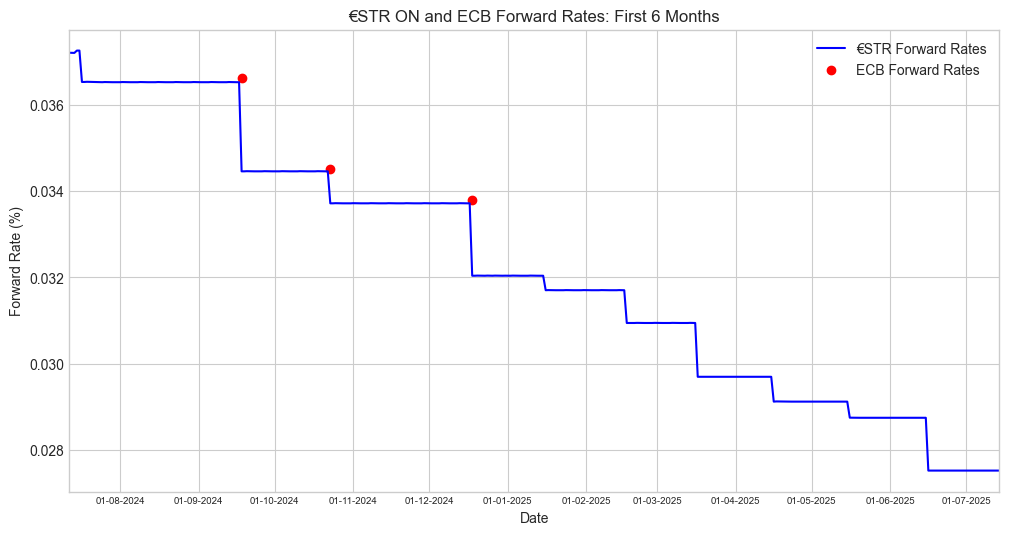

In [17]:
# To simplify analysis, we turn to flat forward rates instead of log-cubic discounts
estr_curve_ff = ql.PiecewiseFlatForward(
    0, ql.TARGET(), estr_helpers, ql.Actual365Fixed()
)
estr_curve_ff.enableExtrapolation()

# Restrict the plot to the first 12 months
end = ql.TARGET().advance(settle_date, ql.Period(12, ql.Months))

# Calculate the forward rates for the first 12 months
dates = [
    ql.Date(serial)
    for serial in range(settle_date.serialNumber(), end.serialNumber() + 1)
]

# Convert QuantLib dates to datetime
dates_dt = [d.to_date() for d in dates]

rates_ff = [
    estr_curve_ff.forwardRate(
        d, ql.TARGET().advance(d, 1, ql.Days), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]




# Convert QuantLib dates in 'Start_Period' to datetime objects
forwards_ois_ecb_data['End_Period_dt'] = forwards_ois_ecb_data['End_Period'].apply(_to_datetime)

# Convert ECB forward dates to datetime
ecb_forward_dates = forwards_ois_ecb_data['End_Period_dt'].tolist()

# Extract ECB forward rates from the 'Mid_Rate' column
ecb_forward_rates = forwards_ois_ecb_data['Mid_Rate'].values/100

# Plot €STR Forward Rates and ECB Forward Rates
plt.figure(figsize=(12, 6))
plt.plot(dates_dt, rates_ff, label='€STR Forward Rates', color='blue', linestyle='-')
plt.scatter(ecb_forward_dates, ecb_forward_rates, label='ECB Forward Rates', color='red', marker='o')

# Set x-axis properties
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%d-%m-%Y'))
plt.gca().tick_params(axis='x', labelsize=7)  # Set the x-axis label size to be smaller

# Set plot limits and labels
plt.xlim(dates_dt[0], dates_dt[-1])
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.title('€STR ON and ECB Forward Rates: First 6 Months')
plt.legend()
plt.grid(True)

# Show the plot
plt.show()



The graph shows a gradual stepwise decrease without abrupt changes. This smooth transition indicates the absence of liquidity jumps both on a monthly and annual basis. Overall, the curve suggests stability and no evident signs of liquidity issues over the observed period. The initial jump is due to the transition from deposit to OIS instruments.

# Section 5: Construction of the 3-Month Euribor Curve - No Synthetic Deposits
In this section, we construct the 3-month Euribor curve without using synthetic deposits. This involves defining the 3-month Euribor instance, adding a 0x3M FRA, futures, and swap rate helpers, and building both the spot and forward curves. The forward curve is then plotted to visualize the 3-month Euribor rates.

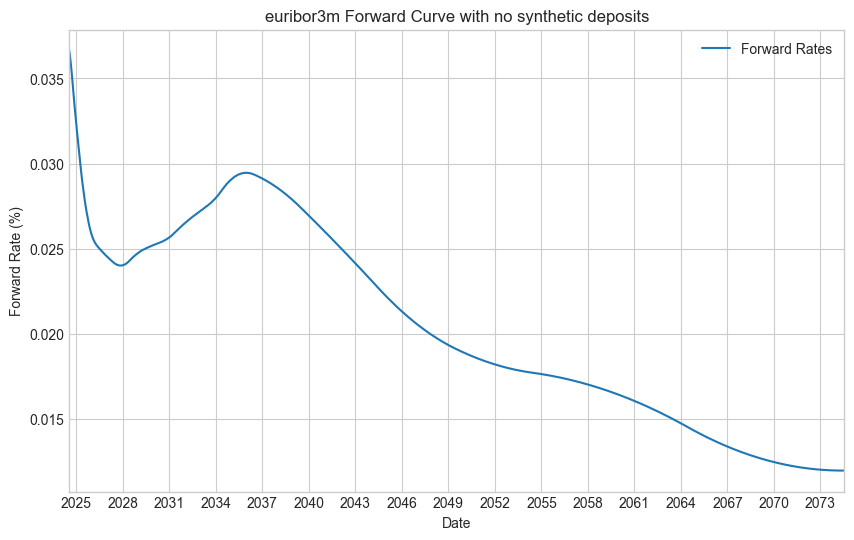

In [18]:
def euribor_curve_builder_no_synth_depo(
    estr_curve=estr_curve,
    fra_data3M=fra_data3M,
    futures_data3M=futures_data3M,
    swap_data3M=swap_data3M,
    futures_maturities_chosen=futures_maturities_chosen,
    swap_maturities_chosen=swap_maturities_chosen,
    dual_curve_approach=True,
    graph=True):

    # Define the 3-month Euribor instance
    euribor3m = ql.Euribor3M()

    # 1) 0x3 FRA
    # First pillar of the EURIBOR curve: the 0x3M FRA
    first_pillar_3m = fra_data3M[fra_data3M['Maturity'] == '0X3']

    fra_0x3_3m_helper = []
    fra_0x3_3m_helper.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(first_pillar_3m['Mid_Rate'].values[0] / 100)),
                                     first_pillar_3m['Start_Period'].values[0], euribor3m))


    # 2) Futures
    # Add futures for the second part of the curve from selected FRA
    future_helpers = []
    selected_data = futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen)]
    for index, row in selected_data.iterrows():
        future_helpers.append(
            ql.FuturesRateHelper(
                ql.QuoteHandle(ql.SimpleQuote((row['Mid_Rate']))),
                row['Start_Date'],
                euribor3m,
                ql.QuoteHandle(),
            )
        )

    # Use €STR as the discount curve for the dual curve approach
    discount_curve = ql.YieldTermStructureHandle(estr_curve)

    
    # 3) Swaps
    # Add helpers for the third part of the curve from selected swaps
    swap_helpers = []
    selected_data = swap_data3M[swap_data3M['Maturity'].isin(swap_maturities_chosen)]

    if dual_curve_approach:
        for index, row in selected_data.iterrows():
            swap_helpers.append(ql.SwapRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
                ql.Thirty360(ql.Thirty360.BondBasis), euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))
    else:
        for index, row in selected_data.iterrows():
            swap_helpers.append(ql.SwapRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
                ql.Thirty360(ql.Thirty360.BondBasis), euribor3m, ql.QuoteHandle(), ql.Period(0, ql.Days)))
            
    # Debug: Print details of all EURIBOR helpers
    DEBUG_EUR = False
    if DEBUG_EUR:
        euribor_helpers = fra_0x3_3m_helper + future_helpers + swap_helpers
        print("Euribor Helpers:")
        for helper in euribor_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    # Build the spot curve
    euribor3m_curve_no_synth_depo = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), fra_0x3_3m_helper + future_helpers + swap_helpers, ql.Actual365Fixed()
    )
    euribor3m_curve_no_synth_depo.enableExtrapolation()

    # Build the forward curve
    spot_date = euribor3m_curve_no_synth_depo.referenceDate()  # Set the evaluation date as the spot date
    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve_no_synth_depo = [
        euribor3m_curve_no_synth_depo.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward EURIBOR curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_no_synth_depo, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlim([dates_dt[0], dates_dt[-1]])
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('euribor3m Forward Curve with no synthetic deposits')
        plt.legend()
        plt.grid(True)
        plt.show()

    return euribor3m_curve_no_synth_depo, euribor3m_f_curve_no_synth_depo, fra_0x3_3m_helper, future_helpers, swap_helpers, spot_date, euribor3m

# Build the Euribor curve with no synthetic deposits
euribor3m_curve_no_synth_depo, euribor3m_f_curve_no_synth_depo, fra_0x3_3m_helper, future_helpers, swap_helpers_dual, spot_date, euribor3m = euribor_curve_builder_no_synth_depo()


# Section 6: Calculation of Basis and Creation of Synthetic Deposits
In this section, we calculate the basis (spread) between the forward 3-month EURIBOR and €STR rates. We then create synthetic deposit helpers for various short-term maturities by adjusting the €STR forward rates with the calculated spread. This process enables the construction of a more accurate 3-month EURIBOR curve.


In [19]:
def synthetic_deposit_builder(
    euribor3m_curve_no_synth_depo=euribor3m_curve_no_synth_depo,
    estr_curve=estr_curve,
    spot_date=spot_date,
    print_alpha=True):
    

# ATTENTION: since we are using a 0x3 FRA -> t1 = 0, so forward rate is equal to the spot rate.
    # Bootstrap the 0X3-month rate from the existing 3-month EURIBOR curve
    euribor3m_0X3M_rate = euribor3m_curve_no_synth_depo.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, 3, ql.Months), ql.Actual360(), ql.Simple).rate()

    # Bootstrap the 0X3-month rate from the €STR curve
    estr_0X3M_rate = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, 3, ql.Months), ql.Actual360(), ql.Simple).rate()

    # Calculate the spread (alpha) between the 3-month forward EURIBOR rate and the 3-month forward €STR rate
    alpha = euribor3m_0X3M_rate - estr_0X3M_rate

    if print_alpha:
        print(f"Alpha: {alpha}")     

    # Construct helpers for synthetic deposits
    synth_deposit_helper_ON_to_2M = []

    # Define a list of tuples representing the maturities for which synthetic deposits will be created
    # Each tuple contains a number (n) and a unit of time (Days, Weeks, Months)
    for n, units in [
        (1, ql.Days),
        (1, ql.Weeks),
        (2, ql.Weeks),
        (3, ql.Weeks),
        (1, ql.Months),
        (2, ql.Months),
    ]:
        # Calculate the synth deposits rates from the €STR curve for the given duration and adjust the Euribor rate by adding the previously calculated spread (alpha)
        estr_0Xx_3M_rate = estr_curve.forwardRate(
            spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
        ).rate()
        
        synth_euribor3m_deposit_rate = estr_0Xx_3M_rate + alpha

        # Create a synthetic deposit helper with the calculated forward rate and add it to the list
        synth_deposit_helper_ON_to_2M.append(
            ql.DepositRateHelper(
                ql.QuoteHandle(ql.SimpleQuote(synth_euribor3m_deposit_rate)),  # Adjusted forward rate
                ql.Period(n, units),  # Duration for the synthetic deposit
                2,  # Settlement days
                ql.TARGET(),  # Calendar
                ql.Following,  # Business day convention
                False,  # End of month flag
                ql.Actual360(),  # Day count convention
            )
        )

    # DEBUG: Print details of each synthetic deposit helper
    DEBUG_SYNTH = False
    if DEBUG_SYNTH:
        print("Synthetic Deposit Helpers:")
        for helper in synth_deposit_helper_ON_to_2M:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    return synth_deposit_helper_ON_to_2M

# Build synthetic deposit helpers
synth_deposit_helper_ON_to_2M = synthetic_deposit_builder()


Alpha: 0.0005511863596106767


# Section 7: Construction of the euribor3m forward Curve with Synthetic Deposits
In this section, we construct the forward Euribor curve using synthetic deposits. We create a combined list of helpers, including synthetic deposits, a 0x3M FRA, futures, and swaps. This combined list is used to build the Euribor curve, which is then plotted to visualize the forward rates.

In [20]:
def euribor_curve_builder_with_synth_depo(
    synth_deposit_helper_ON_to_2M=synth_deposit_helper_ON_to_2M, 
    fra_0x3_3m_helper=fra_0x3_3m_helper,
    future_helpers=future_helpers, 
    swap_helpers_dual=swap_helpers_dual, 
    graph=True):
    
    # Construct the corrected EURIBOR curve using synthetic deposit helpers
    euribor3m_curve_with_synth_depo = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_dual, ql.Actual365Fixed()
    )
    euribor3m_curve_with_synth_depo.enableExtrapolation()

    # DEBUG: Print details of the corrected EURIBOR curve helpers
    DEBUG_EU_CORR = False
    if DEBUG_EU_CORR:
        print("Corrected Euribor Helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_dual:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Helper Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    # Construct the corrected forward EURIBOR curve
    euribor3m_f_curve = [
        euribor3m_curve_with_synth_depo.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]


    return euribor3m_curve_with_synth_depo, euribor3m_f_curve



euribor3m_curve_with_synth_depo, euribor3m_f_curve = euribor_curve_builder_with_synth_depo()


# Section 8: Comparing Forward Euribor Curves With and Without Synthetic Deposits

In this section, we conduct a detailed analysis of the Euribor forward curves, comparing the effects of including synthetic deposits versus excluding them. By calculating forward rates for both approaches, we aim to understand how synthetic deposits influence the short-term rate projections. The analysis includes a focused comparison of the first 6 months to highlight short-term impacts. The plots visually depict the difference between the two methods, with annotations indicating the basis point differences in the short-term curves, thus offering insights into the effects of synthetic deposits on forward rate estimations.

C:\Users\djlor\AppData\Local\Temp\ipykernel_44988\3757702276.py:40: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


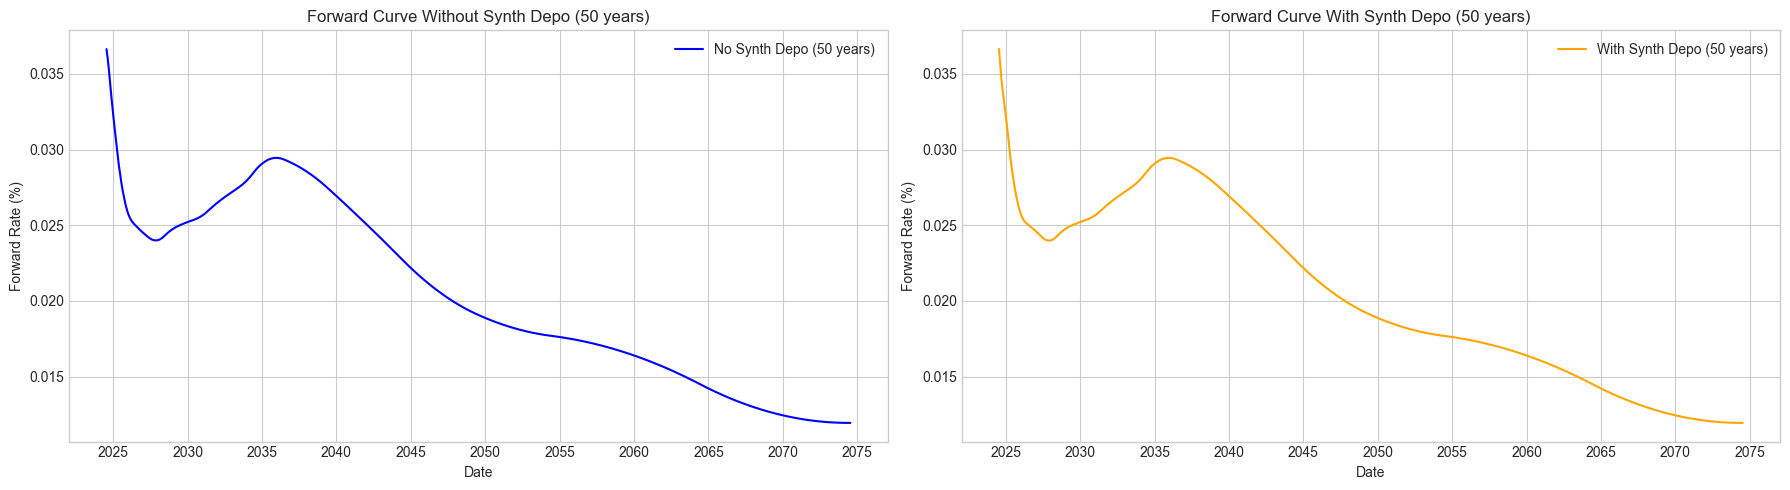

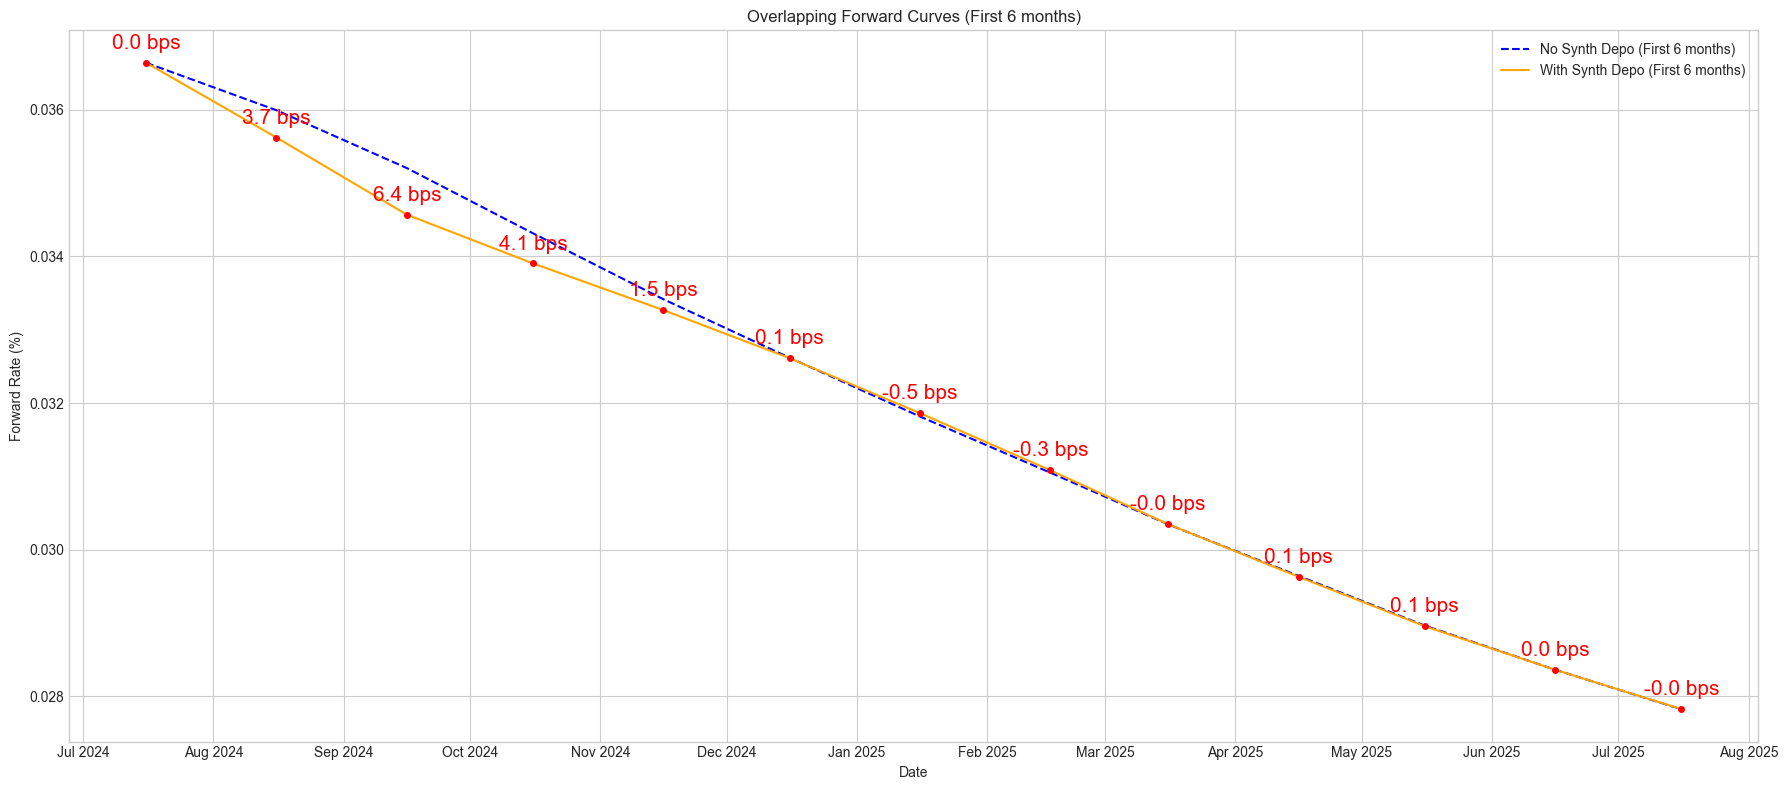

In [21]:


# Calculate dates for 50 years and first 6 months
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
dates_6m = [spot_date + ql.Period(i, ql.Months) for i in range(0, 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]
dates_dt_6m = [_to_datetime(date) for date in dates_6m]

# Calculate forward rates without synthetic deposits for 50 years
euribor3m_f_curve_no_synth_depo = [
    euribor3m_curve_no_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Calculate forward rates with synthetic deposits for 50 years
euribor3m_f_curve = [
    euribor3m_curve_with_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Calculate forward rates without synthetic deposits for the first 6 months
euribor3m_f_curve_no_synth_depo_first6m = [
    euribor3m_curve_no_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates_6m
]

# Calculate forward rates with synthetic deposits for the first 6 months
euribor3m_f_curve_first6m = [
    euribor3m_curve_with_synth_depo.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates_6m
]

# Set the plot style to use seaborn for a clean aesthetic
plt.style.use('seaborn-whitegrid')

# Create the figure for the first two plots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 5))

# Plot 1: Forward Curve Without Synthetic Deposits (50 years)
ax1.plot(dates_dt, euribor3m_f_curve_no_synth_depo, label='No Synth Depo (50 years)', color='blue')
ax1.set_title('Forward Curve Without Synth Depo (50 years)')
ax1.set_xlabel('Date')
ax1.set_ylabel('Forward Rate (%)')
ax1.xaxis.set_major_locator(mdates.YearLocator(5))
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax1.grid(True)
ax1.legend()

# Plot 2: Forward Curve With Synthetic Deposits (50 years)
ax2.plot(dates_dt, euribor3m_f_curve, label='With Synth Depo (50 years)', color='orange')
ax2.set_title('Forward Curve With Synth Depo (50 years)')
ax2.set_xlabel('Date')
ax2.set_ylabel('Forward Rate (%)')
ax2.xaxis.set_major_locator(mdates.YearLocator(5))
ax2.xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
ax2.grid(True)
ax2.legend()

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the first set of plots
plt.show()

# Create the figure for the third plot
plt.figure(figsize=(18, 8))

# Plot 3: Overlapping Curves for the First 6 Months
plt.plot(dates_dt_6m, euribor3m_f_curve_no_synth_depo_first6m, label='No Synth Depo (First 6 months)', color='blue', linestyle='--')
plt.plot(dates_dt_6m, euribor3m_f_curve_first6m, label='With Synth Depo (First 6 months)', color='orange', linestyle='-')
plt.title('Overlapping Forward Curves (First 6 months)')
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.gca().xaxis.set_major_locator(mdates.MonthLocator(interval=1))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.grid(True)
plt.legend()

# Annotate differences in basis points every 1 month
interval = 1  # Annotate every 1 month
for i in range(0, len(dates_dt_6m), interval):
    date = dates_dt_6m[i]
    rate_no_synth = euribor3m_f_curve_no_synth_depo_first6m[i]
    rate_with_synth = euribor3m_f_curve_first6m[i]
    diff = rate_no_synth - rate_with_synth
    diff_bps = diff * 10000  # Convert difference to basis points
    plt.annotate(f'{diff_bps:.1f} bps',
                 (date, rate_with_synth),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=15,
                 color='red')

# Add markers to indicate annotation points
plt.plot(dates_dt_6m[::interval], euribor3m_f_curve_first6m[::interval], 'o', color='red', markersize=4)

# Adjust layout to prevent overlap
plt.tight_layout()

# Display the third plot
plt.show()


# Section 9: Comparison of Dual Curve and Single euribor3m Forward Curves - Discounting impact
In this section, we construct the EURIBOR curves using both single and dual curve approaches. The EURIBOR 3-month zero curve is created using swap helpers, synthetic deposit helpers, a 0x3M FRA, and futures helpers. The dual curve approach captures market conditions accurately, while the single curve approach allows direct comparison without dual calibration. We plot both zero and forward rates, annotating differences in basis points to highlight how future rate expectations diverge over time.

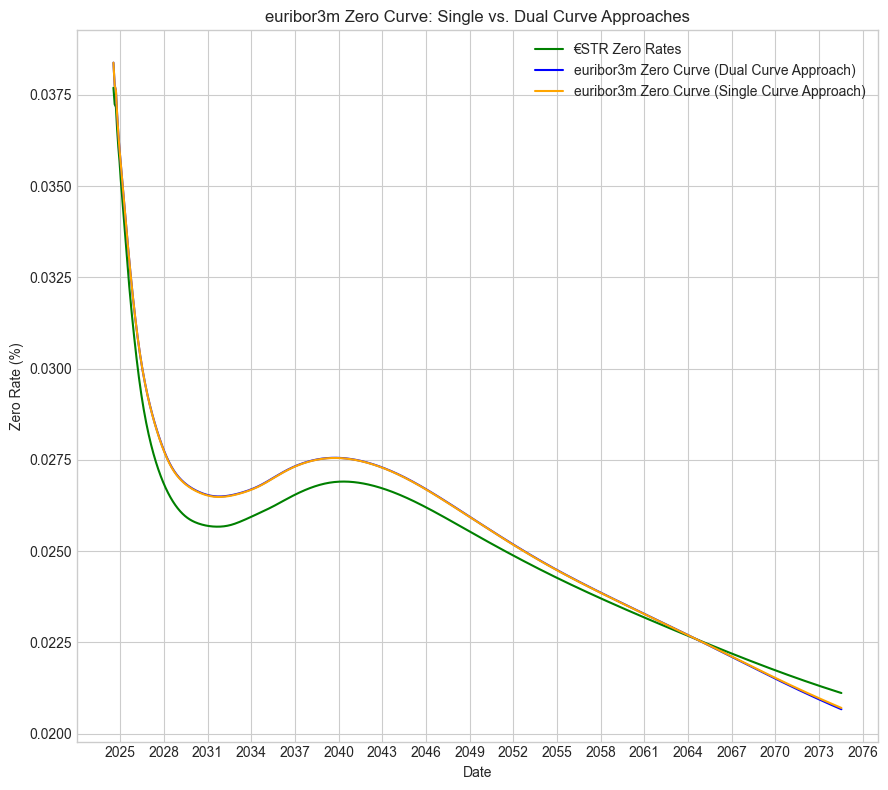

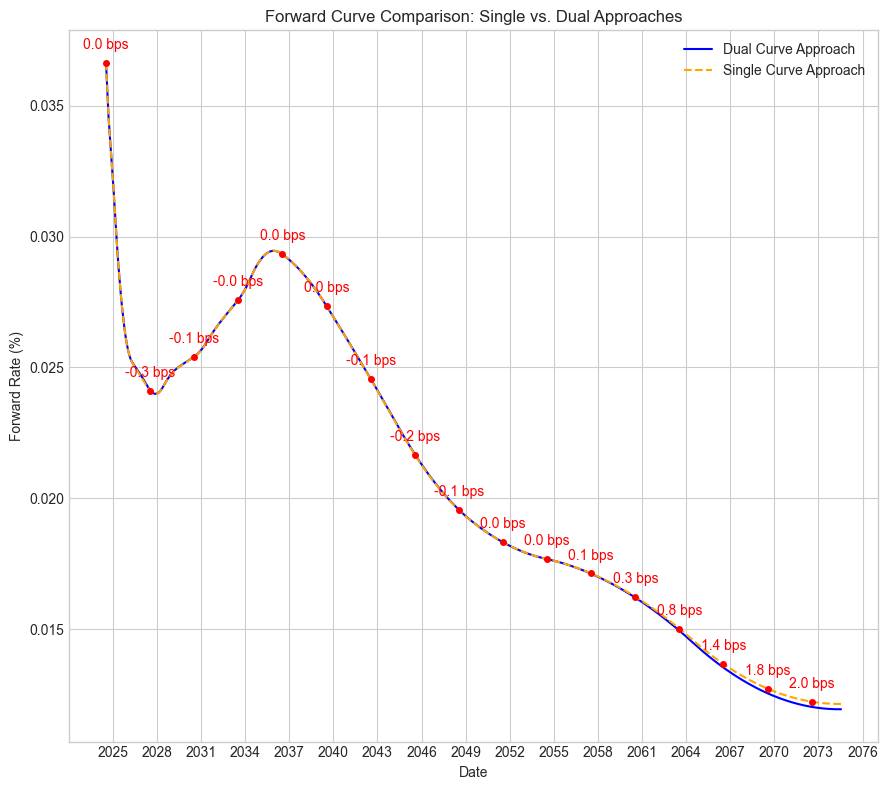

In [22]:
#Set the evaluation date for the curves
dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
dates_dt = [_to_datetime(date) for date in dates]

# Construct the Euribor zero curve 
euribor3m_zero_rates = [
    euribor3m_curve_with_synth_depo.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
    for date in dates
]

# Construct the Euribor curve with single curve approach
_,_,_,_, swap_helpers_single,*_ =   euribor_curve_builder_no_synth_depo(
                                    dual_curve_approach=False,
                                    graph=False)

euribor3m_curve_single = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + future_helpers + swap_helpers_single, ql.Actual365Fixed()
)
euribor3m_curve_single.enableExtrapolation()

# Calculate zero rates for the single curve approach
euribor3m_zero_rates_single = [
    euribor3m_curve_single.zeroRate(date, ql.Actual365Fixed(), ql.Continuous).rate()
    for date in dates
]

# Construct the forward curve for the single curve approach
euribor3m_f_curve_single = [
    euribor3m_curve_single.forwardRate(
        d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# First plot: €STR Zero Rates + euribor3m Zero Curves (Single vs Dual Approach)

# Create a new figure
plt.figure(figsize=(9, 8))

# Plot
plt.plot(dates_dt, estr_zero_rates, label='€STR Zero Rates', color='green')
plt.plot(dates_dt, euribor3m_zero_rates, label='euribor3m Zero Curve (Dual Curve Approach)', color='blue')
plt.plot(dates_dt, euribor3m_zero_rates_single, label='euribor3m Zero Curve (Single Curve Approach)', color='orange')
plt.title('euribor3m Zero Curve: Single vs. Dual Curve Approaches')
plt.xlabel('Date')
plt.ylabel('Zero Rate (%)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

# Second plot: Forward Curves for Single vs Dual Approach with Annotations

# Create a new figure
plt.figure(figsize=(9, 8))

# Plot
plt.plot(dates_dt, euribor3m_f_curve, label='Dual Curve Approach', color='blue')
plt.plot(dates_dt, euribor3m_f_curve_single, label='Single Curve Approach', color='orange', linestyle='--')
plt.title('Forward Curve Comparison: Single vs. Dual Approaches')
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))

# Add annotations
interval = 36  # Annotate every 12 months (1 year)
for i in range(0, len(dates_dt), interval):
    date = dates_dt[i]
    rate_dual = euribor3m_f_curve[i]
    rate_single = euribor3m_f_curve_single[i]
    diff = rate_single - rate_dual
    diff_bps = diff * 10000  # Convert difference to basis points
    plt.annotate(f'{diff_bps:.1f} bps',
                 (date, rate_single),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=10,
                 color='red')

# Add markers to indicate annotation points
plt.plot(dates_dt[::interval], euribor3m_f_curve_single[::interval], 'o', color='red', markersize=4)

# Add grid, legend, and display the plot
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


# Section 10: Construction of the Euribor6M Forward Curve and comparison with the euribor3m Forward Curve - The importance of being tenor consistent
In this section, we construct the forward Euribor6M curve using the dual curve approach. We then compare the Euribor6M forward curve with the euribor3m forward curve to identify any differences between the two curves.

C:\Users\djlor\AppData\Local\Temp\ipykernel_44988\251679456.py:123: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


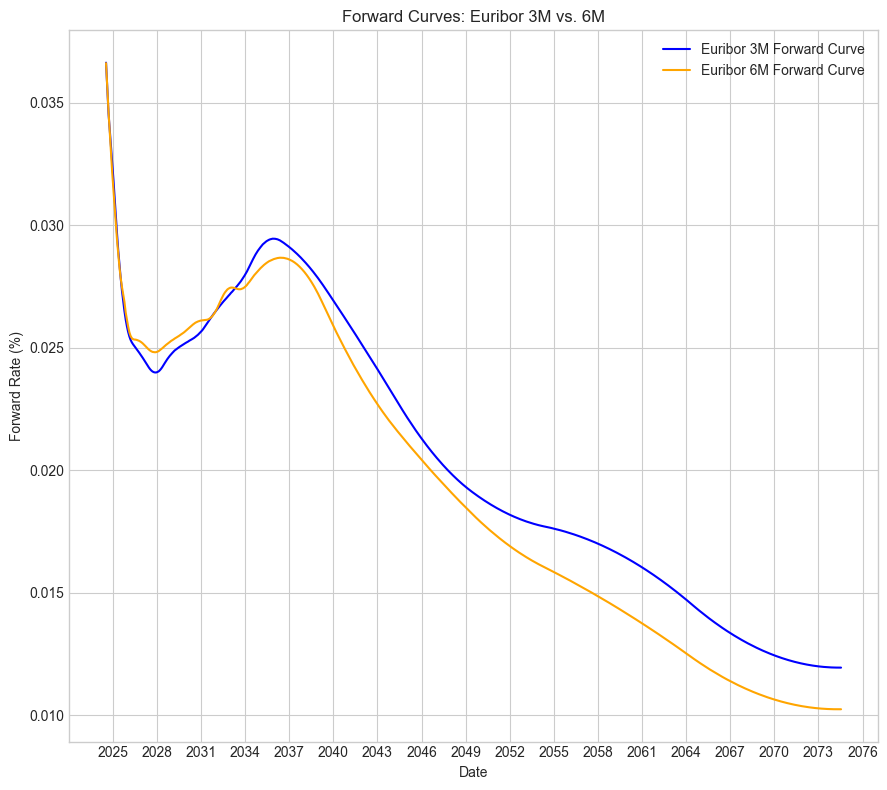

C:\Users\djlor\AppData\Local\Temp\ipykernel_44988\251679456.py:144: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-whitegrid')


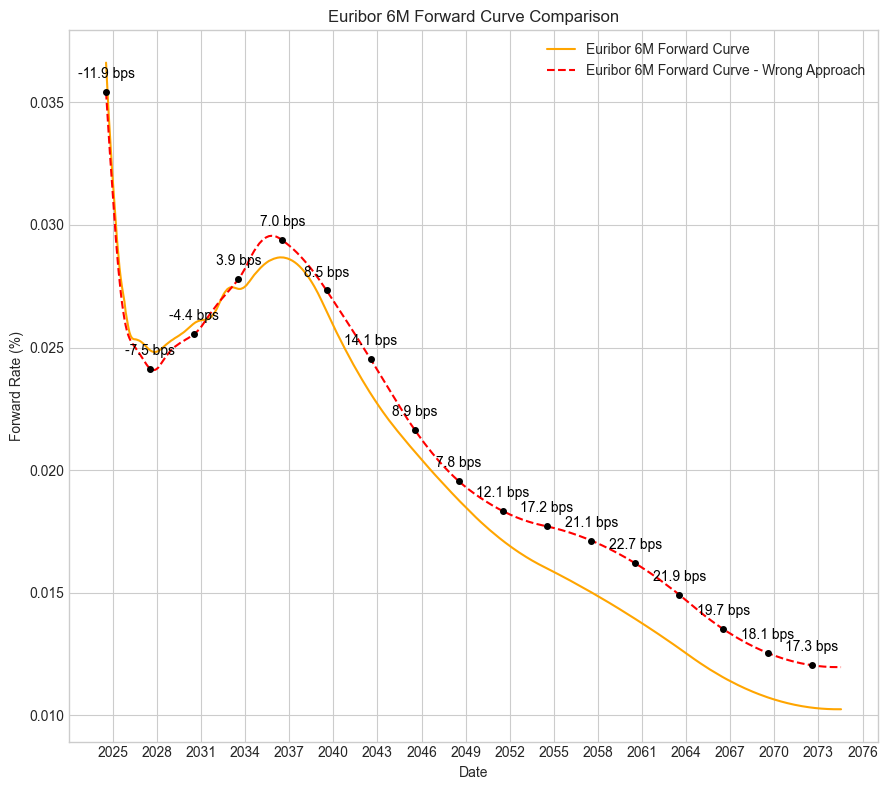

In [23]:
euribor6m = ql.Euribor6M()
# 1) FRA 0x6
# Primo pillar della curva EURIBOR 
first_pillar_6m = fra_data6M[fra_data6M['Maturity'] == '0X6']

fra_0x6_6m_helper = []
fra_0x6_6m_helper.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(first_pillar_6m['Mid_Rate'].values[0] / 100)),
                                    first_pillar_6m['Start_Period'].values[0], euribor6m))
# 2) FRA
# Aggiungo gli helpers per la seconda parte della curva dai FRA (2 anni)
fra_helpers_6m = []
for index, row in fra_data6M.iloc[1:].iterrows():
    fra_helpers_6m.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                     row['Start_Period'], euribor6m))

discount_curve = ql.YieldTermStructureHandle(estr_curve)

# 3) SWAP
# Aggiungo gli helpers per la terza parte della curva dai SWAP
swap_helpers_6m = []
selected_data = swap_data6M[swap_data6M['Maturity'].isin(swap_maturities_chosen)]
for index, row in selected_data.iterrows():
    swap_helpers_6m.append(ql.SwapRateHelper(
        ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), row['Period'], ql.TARGET(), ql.Annual, ql.Unadjusted,
        ql.Thirty360(ql.Thirty360.BondBasis), euribor6m, ql.QuoteHandle(), ql.Period(0, ql.Days), discount_curve))

# Build the spot curve
euribor6m_curve_no_synth_depo = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), fra_0x6_6m_helper + fra_helpers_6m + swap_helpers_6m, ql.Actual365Fixed()
)
euribor6m_curve_no_synth_depo.enableExtrapolation()

#======================build and add synthetic deposits====================

# Set the spot date to one day after the settlement date (fixing convention)
d = ql.TARGET().advance(spot_date, 1, ql.Days)

# Bootsrap del tasso forward a 6 mesi dalla curva EURIBOR a 6 mesi preesistente
euribor6m_forward_curve_no_synth_depo = euribor6m_curve_no_synth_depo.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap the forward 6-month rate from the existing 6-month EURIBOR curve
euribor6m_0X6M_rate = euribor6m_curve_no_synth_depo.forwardRate(
    spot_date, ql.TARGET().advance(spot_date, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Bootstrap the forward 6-month rate from the €STR curve
estr_0X6M_rate = estr_curve.forwardRate(
    d, ql.TARGET().advance(d, 6, ql.Months), ql.Actual360(), ql.Simple).rate()

# Calculate the spread (alpha) between the 6-month forward EURIBOR rate and the 3-month forward €STR rate
alpha = euribor6m_0X6M_rate - estr_0X6M_rate

# Construct helpers for synthetic deposits
synth_deposit_helper_ON_to_5M = []

for n, units in [
    (1, ql.Days),
    (1, ql.Weeks),
    (2, ql.Weeks),
    (3, ql.Weeks),
    (1, ql.Months),
    (2, ql.Months),
    (3, ql.Months),
    (4, ql.Months),
    (5, ql.Months),
]:
        # Calculate the forward rate from the €STR curve for the given duration and adjust the Euribor forward rate by adding the previously calculated spread (alpha)
    estr_0Xx_6M_rate = estr_curve.forwardRate(
        spot_date, ql.TARGET().advance(spot_date, n, units), ql.Actual360(), ql.Simple
    ).rate()
    
    synth_euribor6M_0Xx__deposit_rate = estr_0Xx_6M_rate + alpha

    # Create a synthetic deposit helper with the calculated forward rate and add it to the list
    synth_deposit_helper_ON_to_5M.append(
        ql.DepositRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(synth_euribor6M_0Xx__deposit_rate)),  # Adjusted forward rate
            ql.Period(n, units),  # Duration for the synthetic deposit
            2,  # Settlement days
            ql.TARGET(),  # Calendar
            ql.Following,  # Business day convention
            False,  # End of month flag
            ql.Actual360(),  # Day count convention
        )
    )

euribor6m_curve = ql.PiecewiseLogCubicDiscount(
    2, ql.TARGET(), synth_deposit_helper_ON_to_5M + fra_0x6_6m_helper + fra_helpers_6m + swap_helpers_6m, ql.Actual365Fixed()
)
euribor6m_curve.enableExtrapolation()


# DEBUG: Print details of each synthetic deposit helper
DEBUG_6M = False
if DEBUG_6M:
    print(" Euribor 6M Helpers:")
    for helper in synth_deposit_helper_ON_to_5M + fra_0x6_6m_helper + fra_helpers_6m + swap_helpers_6m:
        helper_type = type(helper).__name__
        start_date = helper.earliestDate()
        maturity_date = helper.maturityDate()
        quote = helper.quote().value()
        print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")



# Build the forward curve
euribor6m_f_curve = [
    euribor6m_curve.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Calculate the forward rates using the wrong approach
euribor6m_f_curve_wrong = [
    euribor3m_curve_with_synth_depo.forwardRate(
        d, euribor6m.maturityDate(d), ql.Actual360(), ql.Simple
    ).rate()
    for d in dates
]

# Set up the plot style
plt.style.use('seaborn-whitegrid')

# Create figure for the first plot
plt.figure(figsize=(9, 8))

# Plot 1: Euribor 3M vs 6M Forward Curves
plt.plot(dates_dt, euribor3m_f_curve, label='Euribor 3M Forward Curve', color='blue')
plt.plot(dates_dt, euribor6m_f_curve, label='Euribor 6M Forward Curve', color='orange')
plt.title('Forward Curves: Euribor 3M vs. 6M')
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.legend()

# Display the first plot
plt.tight_layout()
plt.show()

# Set up the plot style
plt.style.use('seaborn-whitegrid')

# Create figure for the second plot
plt.figure(figsize=(9, 8))

# Plot 2: Euribor 6M Forward Curve vs. Wrong Approach
plt.plot(dates_dt, euribor6m_f_curve, label='Euribor 6M Forward Curve', color='orange')
plt.plot(dates_dt, euribor6m_f_curve_wrong, label='Euribor 6M Forward Curve - Wrong Approach', color='red', linestyle='--')
plt.title('Euribor 6M Forward Curve Comparison')
plt.xlabel('Date')
plt.ylabel('Forward Rate (%)')
plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
plt.grid(True)
plt.legend()

# Annotate differences in basis points between the correct and wrong 6M forward curves
interval =  36  # Annotate every 12 months (1 year)
for i in range(0, len(dates_dt), interval):
    date = dates_dt[i]
    rate_correct = euribor6m_f_curve[i]
    rate_wrong = euribor6m_f_curve_wrong[i]
    diff = rate_wrong - rate_correct
    diff_bps = diff * 10000  # Convert difference to basis points
    plt.annotate(f'{diff_bps:.1f} bps',
                 (date, rate_wrong),
                 textcoords="offset points",
                 xytext=(0, 10),
                 ha='center',
                 fontsize=10,
                 color='black')

# Add markers to indicate annotation points
plt.plot(dates_dt[::interval], euribor6m_f_curve_wrong[::interval], 'o', color='black', markersize=4)

# Display the second plot
plt.tight_layout()
plt.show()



# Section 11: Constructing and Evaluating euribor3m Forward Curves via Diverse Bootstrapping Instrument Configurations
In this section, we develop and evaluate euribor3m forward curves utilizing various bootstrapping instrument configurations to assess their impact on curve construction. We investigate four distinct combinations that incorporate different financial instruments, such as synthetic deposits, futures, FRAs, and swaps, each tailored to focus on specific market dynamics. Through a dual curve approach, each combination is crafted to examine the sensitivity and robustness of the forward curve under different market assumptions. These curves are then systematically plotted, allowing for a comparative analysis of their structural variations and forward rate projections over a 50-year horizon, thereby elucidating the strategic implications of each bootstrapping methodology on curve modeling.

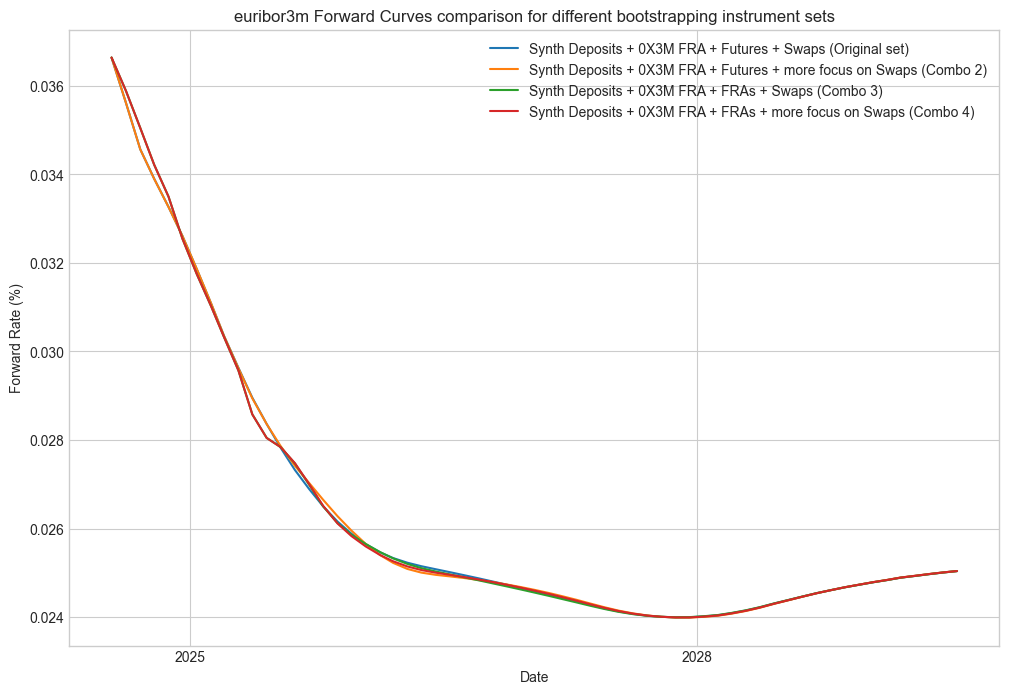

In [24]:
def different_i_b_sets_curves_builder(
    synth_deposit_helper_ON_to_2M=synth_deposit_helper_ON_to_2M, 
    fra_0x3_3m_helper=fra_0x3_3m_helper,
    swap_helpers_dual=swap_helpers_dual, 
    estr_curve=estr_curve,
    euribor3m_curve_with_synth_depo=euribor3m_curve_with_synth_depo,
    futures_data3M=futures_data3M,
    swap_data3M=swap_data3M, 
    fra_data3M=fra_data3M,
    graph=False, 
    graph_comparison=True):

    #========================Combination 2: Greater focus on swaps ===========================================
    futures_maturities_chosen_combo2 = ['DEC4', 'MAR5', 'JUN5'] # We cannot reduce the maturities of the futures further or the algorithm will not converge
    focus_swap_maturities_chosen = ['18M','2Y', '3Y', '4Y', '5Y', '6Y', '7Y', '8Y', '9Y', '10Y', '12Y', '15Y', '20Y', '25Y', '30Y', '40Y', '50Y']

    # The 0x3M FRA and SYNTHETIC DEPOSITS are the same as in combination 1

    # FUTURES
    selected_data = futures_data3M[futures_data3M['Maturity'].isin(futures_maturities_chosen_combo2)]
    futures_helpers_combo2 = []
    for index, row in selected_data.iterrows():
        futures_helpers_combo2.append(
            ql.FuturesRateHelper(
                ql.QuoteHandle(ql.SimpleQuote((row['Mid_Rate']))),
                row['Start_Date'],
                euribor3m,
                ql.QuoteHandle(),
            )
        )

    # SWAPS
    discount_curve = ql.YieldTermStructureHandle(estr_curve)
    focus_swap_helpers = []
    selected_data = swap_data3M[swap_data3M['Maturity'].isin(focus_swap_maturities_chosen)]
    for index, row in selected_data.iterrows():
        focus_swap_helpers.append(ql.SwapRateHelper(
            ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)), 
            row['Period'], 
            ql.TARGET(), 
            ql.Annual, 
            ql.Unadjusted,
            ql.Thirty360(ql.Thirty360.BondBasis), 
            euribor3m, 
            ql.QuoteHandle(), 
            ql.Period(0, ql.Days), 
            discount_curve))
        
    # DEBUG: Print details of EURIBOR combo 2 helpers
    DEBUG_EU_COMBO2 = False
    if DEBUG_EU_COMBO2:
        print("Euribor combo 2 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + futures_helpers_combo2 + focus_swap_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")

    # Build the curve
    all_helpers_combo2 = synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + futures_helpers_combo2 + focus_swap_helpers 

    euribor3m_curve_combo2 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo2, ql.Actual365Fixed()
    )
    euribor3m_curve_combo2.enableExtrapolation()

    # Build the forward curve
    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 50 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve_combo2 = [
        euribor3m_curve_combo2.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_combo2, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('3M Euribor Forward Curve: Synth Deposits + 3MDeposit + Futures + more focus on Swaps (Combo 2)')
        plt.legend()
        plt.grid(True)
        plt.show()

    #=================================Combination 3: SYNTH DEPOSITIS, FRA and SWAPS===================================

    # SYNTHETIC DEPOSITS, the 0x3M FRA and SWAPS are the same as in combination 1

    # FRA
    fra_helpers_combo3 = []
    for index, row in fra_data3M.iloc[1:].iterrows():
        fra_helpers_combo3.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                        row['Start_Period'], euribor3m))

    DEBUG_EU_COMBO3 = False
    if DEBUG_EU_COMBO3:
        print("Euribor combo 3 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + fra_helpers_combo3+ swap_helpers_dual:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    # Build the curve
    all_helpers_combo3 = synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + fra_helpers_combo3 + swap_helpers_dual

    euribor3m_curve_combo3 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo3, ql.Actual365Fixed()
    )

    euribor3m_curve_combo3.enableExtrapolation()

    # Build the forward curve
    euribor3m_f_curve_combo3 = [
        euribor3m_curve_combo3.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_combo3, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('euribor3m Forward curve: Synth Deposits + 3MDeposit + FRAs + Swaps (Combo 3)')
        plt.legend()
        plt.grid(True)
        plt.show()

    #====================Combination 4: FRA with focus on swaps===============================

    fra3M_maturities_chosen_combo4 = ['1X4','2X5','3X6','4X7','5X8','6X9','7X10','8X11','9X12','10X13','12X15']

    # The 0x3M FRA and SYNTHETIC DEPOSITS are the same as in combination 1 and SWAPS are the same as in combination 2

    # FRA
    fra_helpers_combo4 = []
    selected_data = fra_data3M[fra_data3M['Maturity'].isin(fra3M_maturities_chosen_combo4)]
    for index, row in selected_data.iterrows():
        fra_helpers_combo4.append(ql.FraRateHelper(ql.QuoteHandle(ql.SimpleQuote(row['Mid_Rate'] / 100)),
                                        row['Start_Period'], euribor3m))

    DEBUG_EU_COMBO4 = False
    if DEBUG_EU_COMBO4:
        print("Euribor combo 4 helpers:")
        for helper in synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + fra_helpers_combo4+ focus_swap_helpers:
            helper_type = type(helper).__name__
            start_date = helper.earliestDate()
            maturity_date = helper.maturityDate()
            quote = helper.quote().value()
            print(f"Type: {helper_type}, Start Date: {start_date}, Maturity Date: {maturity_date}, Quote: {quote}")
            
    # Build the EURIBOR curve
    all_helpers_combo4 = synth_deposit_helper_ON_to_2M + fra_0x3_3m_helper + fra_helpers_combo4 + focus_swap_helpers

    euribor3m_curve_combo4 = ql.PiecewiseLogCubicDiscount(
        2, ql.TARGET(), all_helpers_combo4, ql.Actual365Fixed()
    )

    euribor3m_curve_combo4.enableExtrapolation()

    # Build the EURIBOR forward curve

    euribor3m_f_curve_combo4 = [
        euribor3m_curve_combo4.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the forward curve
    if graph:
        plt.figure(figsize=(10, 6))
        plt.plot(dates_dt, euribor3m_f_curve_combo4, label='Forward Rates')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('euribor3m Forward Curve: Synth Deposits + 3MDeposit + FRAs + more focus on Swaps (Combo 4)')
        plt.legend()
        plt.grid(True)
        plt.show()

    #==================COMBINED COMPARISON PLOT OF ALL 4 COMBINATIONS=============================

    # Combined plot

    dates = [spot_date + ql.Period(i, ql.Months) for i in range(0, 5 * 12 + 1)]
    dates_dt = [_to_datetime(date) for date in dates]

    euribor3m_f_curve = [
        euribor3m_curve_with_synth_depo.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo2 = [
        euribor3m_curve_combo2.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo3 = [
        euribor3m_curve_combo3.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    euribor3m_f_curve_combo4 = [
        euribor3m_curve_combo4.forwardRate(
            d, euribor3m.maturityDate(d), ql.Actual360(), ql.Simple
        ).rate()
        for d in dates
    ]

    # Plot the combined comparison of all 4 combinations
    if graph_comparison:
        plt.figure(figsize=(12, 8))
        plt.plot(dates_dt, euribor3m_f_curve, label='Synth Deposits + 0X3M FRA + Futures + Swaps (Original set)')
        plt.plot(dates_dt, euribor3m_f_curve_combo2, label='Synth Deposits + 0X3M FRA + Futures + more focus on Swaps (Combo 2)')
        plt.plot(dates_dt, euribor3m_f_curve_combo3, label='Synth Deposits + 0X3M FRA + FRAs + Swaps (Combo 3)')
        plt.plot(dates_dt, euribor3m_f_curve_combo4, label='Synth Deposits + 0X3M FRA + FRAs + more focus on Swaps (Combo 4)')
        plt.gca().xaxis.set_major_locator(mdates.YearLocator(3))
        plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
        plt.xlabel('Date')
        plt.ylabel('Forward Rate (%)')
        plt.title('euribor3m Forward Curves comparison for different bootstrapping instrument sets')
        plt.legend()
        plt.grid(True)
        plt.show()
    
    return euribor3m_f_curve, euribor3m_f_curve_combo2, euribor3m_f_curve_combo3, euribor3m_f_curve_combo4, dates

euribor3m_f_curve, euribor3m_f_curve_combo2, euribor3m_f_curve_combo3, euribor3m_f_curve_combo4, dates = different_i_b_sets_curves_builder()


# Section 12: Stability Assessment of Bootstrapping Sets

This section evaluates the stability of euribor3m forward curve bootstrapping sets through 1000 simulated market shocks. We apply random shifts to bid-ask prices while preserving positive spreads, mimicking market stress. Each simulation rebuilds forward curves with different instrument combinations.

We measure stability using tracking errors and statistical metrics to assess sensitivity. Subplots illustrate the comparison between original and simulated curves, revealing the impact of shocks on each bootstrapping set.



Simulation 4 failed due to convergence error: convergence not reached after 99 iterations; last improvement 3.62543e-12, required accuracy 1e-12
Simulation 17 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.40825e-12, required accuracy 1e-12
Simulation 20 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.3211e-12, required accuracy 1e-12
Simulation 21 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.44234e-12, required accuracy 1e-12
Simulation 34 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.24683e-12, required accuracy 1e-12
Simulation 36 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.04421e-12, required accuracy 1e-12
Simulation 38 failed due to convergence error: convergence not reached after 99 iterations; last improvement 4.36429e-12, requ

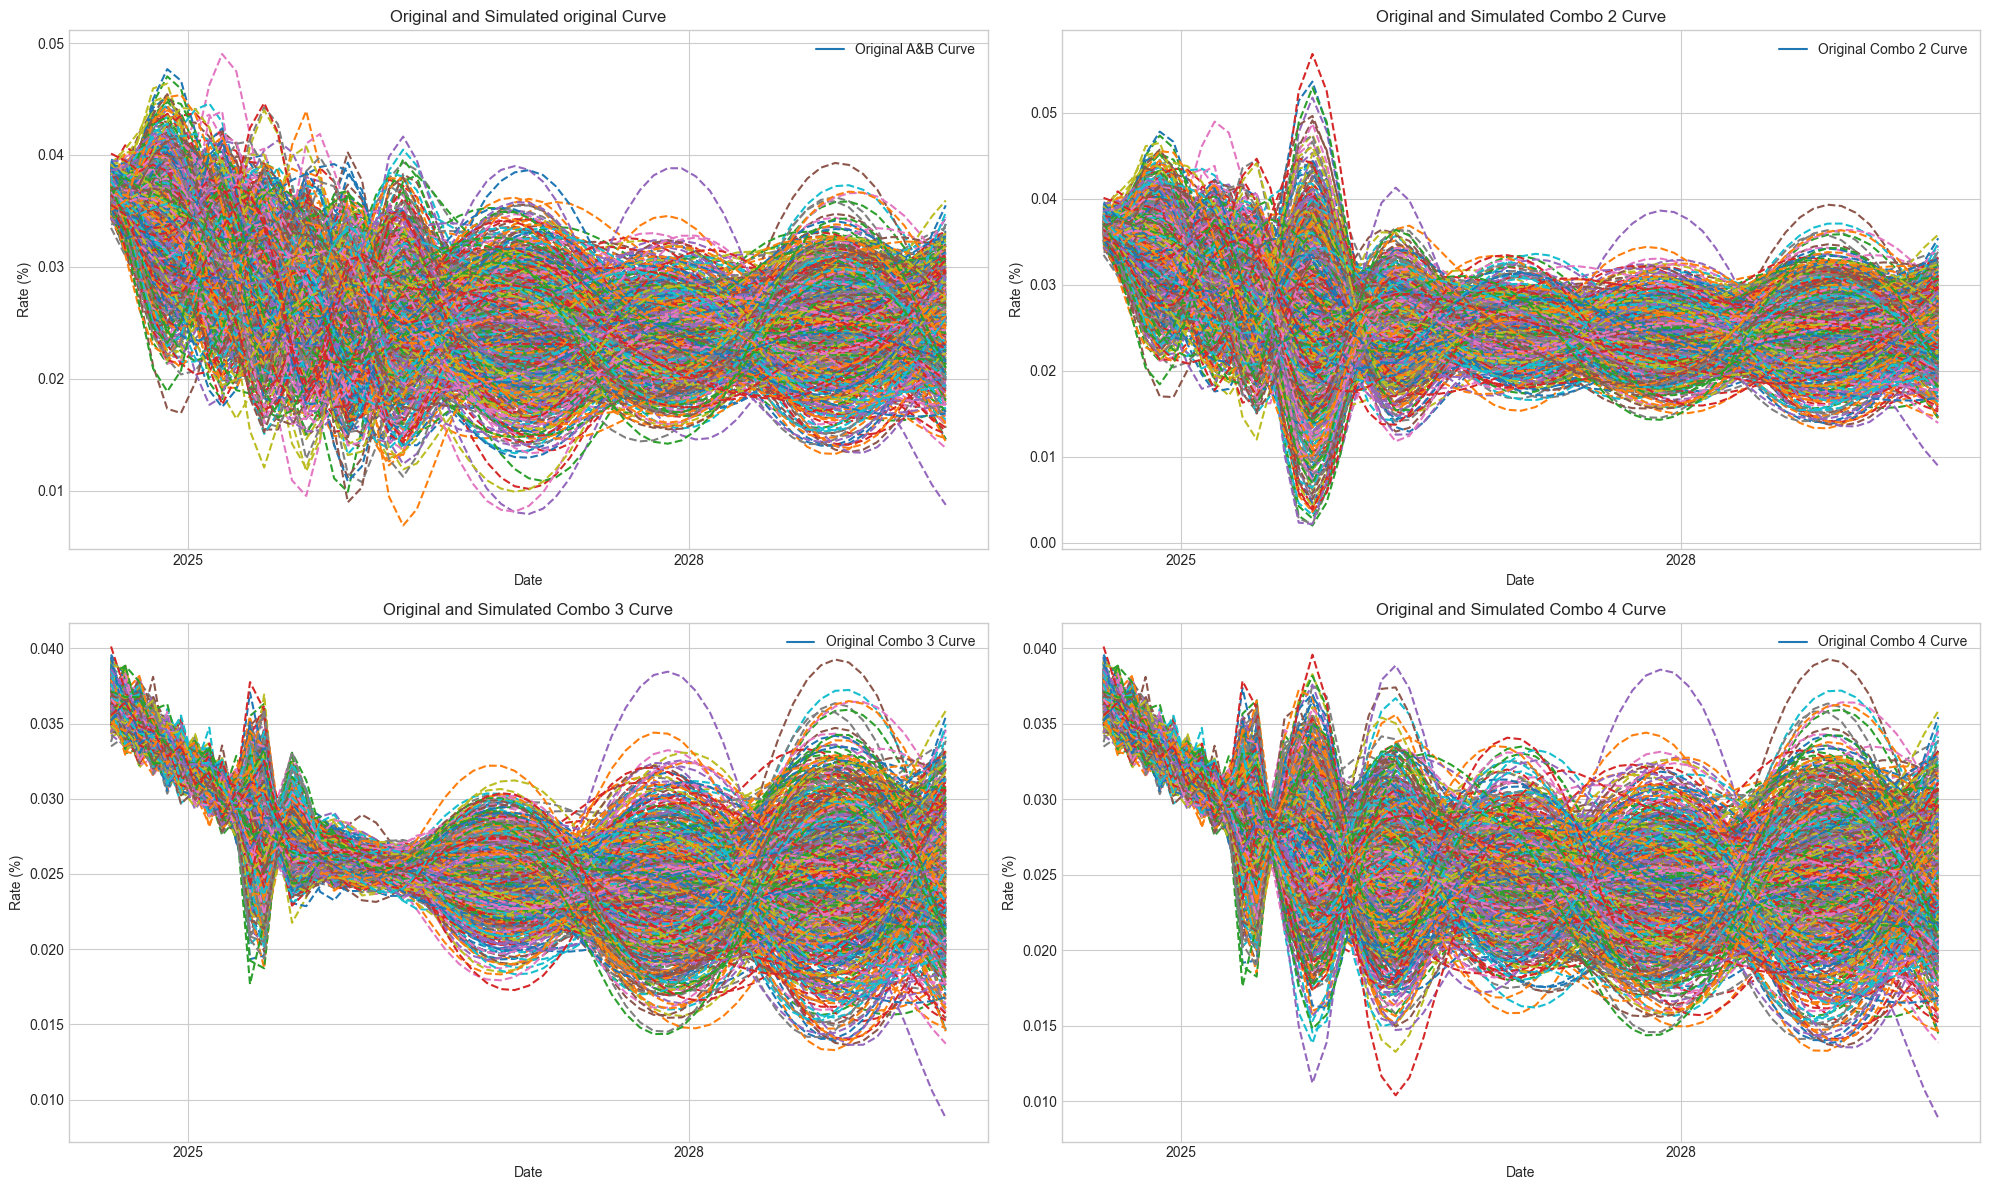

In [25]:
num_simulations = 1000

# Funzione per generare variabili casuali con media zero e deviazione standard pari alla media dello spread
def generate_random_variable(spread, size):
    std_dev = spread.mean()
    return np.random.normal(0, std_dev, size)

# Funzione per applicare lo shock ai dati mantenendo il bid-ask spread positivo
def apply_shock(data, num_simulations):
    data['Spread'] = data['Ask'] - data['Bid']
    simulations = []

    for _ in range(num_simulations):
        random_variable = generate_random_variable(data['Spread'], len(data))
        bid_shocked = data['Bid'] * (1 + random_variable)
        ask_shocked = data['Ask'] * (1 + random_variable)

        # Assicurarsi che il bid-ask spread sia sempre positivo
        ask_shocked = np.where(bid_shocked >= ask_shocked, bid_shocked + abs(data['Spread']), ask_shocked)

        shocked_data = data.copy()
        shocked_data['Bid'] = bid_shocked
        shocked_data['Ask'] = ask_shocked
        shocked_data['Shocked_Spread'] = shocked_data['Ask'] - shocked_data['Bid']
        shocked_data['Mid_Rate'] = (shocked_data['Bid'] + shocked_data['Ask']) / 2

        simulations.append(shocked_data.copy()) 

    return simulations

# Applicazione degli shock e ricostruzione delle curve per ogni simulazione
s_ois_data_sim = apply_shock(ois_data, num_simulations)
s_deposit_data_sim = apply_shock(deposit_data, num_simulations)
s_fra_data3M_sim = apply_shock(fra_data3M, num_simulations)
s_forwards_ois_ecb_data_sim = apply_shock(forwards_ois_ecb_data, num_simulations)
s_swap_data3M_sim = apply_shock(swap_data3M, num_simulations)
s_futures_data3M_sim = apply_shock(futures_data3M, num_simulations)


DEBUG_SHIFTDATA = False
if DEBUG_SHIFTDATA:

    for i in range(num_simulations):
        print(s_ois_data_sim[i].head(10))

# Placeholder per curve
euribor3m_f_curve_sim = []
euribor3m_f_curve_combo2_sim = []
euribor3m_f_curve_combo3_sim = []
euribor3m_f_curve_combo4_sim = []

# Placeholder per tracking errors e metriche di errore
tracking_errors_original_set = []
tracking_errors_combo2 = []
tracking_errors_combo3 = []
tracking_errors_combo4 = []

max_variation_original_set = []
min_variation_original_set = []

max_variation_combo2 = []
min_variation_combo2 = []

max_variation_combo3 = []
min_variation_combo3 = []

max_variation_combo4 = []
min_variation_combo4 = []

for i in range(num_simulations):
    try:
        s_estr_curve, s_estr_helpers, s_zero_rates = estr_curve_builder(

            ois_data=s_ois_data_sim[i],
                deposit_data=s_deposit_data_sim[i],
                    forwards_ois_ecb_data=s_forwards_ois_ecb_data_sim[i],
                        graph=False
        )

        s_euribor3m_curve_no_synth_depo, s_euribor3m_f_curve_no_synth_depo, s_fra_0x3_3m_helper, s_future_helpers, s_swap_helpers_dual, spot_date, euribor3m = euribor_curve_builder_no_synth_depo(

            estr_curve=s_estr_curve,
                fra_data3M=s_fra_data3M_sim[i],
                    futures_data3M=s_futures_data3M_sim[i],
                            swap_data3M=s_swap_data3M_sim[i],
                                graph=False
        )

        s_synth_deposit_helper_ON_to_2M = synthetic_deposit_builder(

            euribor3m_curve_no_synth_depo=s_euribor3m_curve_no_synth_depo,
                estr_curve=s_estr_curve,
                    print_alpha=False
        )

        s_euribor3m_curve_with_synth_depo, s_euribor3m_f_curve = euribor_curve_builder_with_synth_depo(

            synth_deposit_helper_ON_to_2M=s_synth_deposit_helper_ON_to_2M,
                fra_0x3_3m_helper=s_fra_0x3_3m_helper,
                    future_helpers=s_future_helpers,
                        swap_helpers_dual=s_swap_helpers_dual,
                            graph=False
        )

        s_euribor3m_f_curve, s_euribor3m_f_curve_combo2, s_euribor3m_f_curve_combo3, s_euribor3m_f_curve_combo4, dates = different_i_b_sets_curves_builder(

            synth_deposit_helper_ON_to_2M=s_synth_deposit_helper_ON_to_2M,
                fra_0x3_3m_helper=s_fra_0x3_3m_helper,
                    swap_helpers_dual=s_swap_helpers_dual,
                        estr_curve=s_estr_curve,
                            euribor3m_curve_with_synth_depo=s_euribor3m_curve_with_synth_depo,
                                futures_data3M=s_futures_data3M_sim[i],
                                    swap_data3M=s_swap_data3M_sim[i],
                                        fra_data3M=s_fra_data3M_sim[i],
                                            graph=False,
                                                graph_comparison=False,
        )

        euribor3m_f_curve_sim.append(s_euribor3m_f_curve)
        euribor3m_f_curve_combo2_sim.append(s_euribor3m_f_curve_combo2)
        euribor3m_f_curve_combo3_sim.append(s_euribor3m_f_curve_combo3)
        euribor3m_f_curve_combo4_sim.append(s_euribor3m_f_curve_combo4)

        #=========================Statistical Analysis============================================

        # Calculate Differences Between Curves
        differences_original_set = np.array(euribor3m_f_curve) - np.array(s_euribor3m_f_curve)
        differences_combo2 = np.array(euribor3m_f_curve_combo2) - np.array(s_euribor3m_f_curve_combo2)
        differences_combo3 = np.array(euribor3m_f_curve_combo3) - np.array(s_euribor3m_f_curve_combo3)
        differences_combo4 = np.array(euribor3m_f_curve_combo4) - np.array(s_euribor3m_f_curve_combo4)

        # Calculate Tracking Error and other metrics (in basis points) for the first 10 years
        tracking_error_original_set = np.sqrt(np.mean(differences_original_set**2)) * 10000
        tracking_error_combo2 = np.sqrt(np.mean(differences_combo2**2)) * 10000
        tracking_error_combo3 = np.sqrt(np.mean(differences_combo3**2)) * 10000
        tracking_error_combo4 = np.sqrt(np.mean(differences_combo4**2)) * 10000

        # Append tracking errors to the lists
        tracking_errors_original_set.append(tracking_error_original_set)
        tracking_errors_combo2.append(tracking_error_combo2)
        tracking_errors_combo3.append(tracking_error_combo3)
        tracking_errors_combo4.append(tracking_error_combo4)

        # Append max and min variations to the lists
        max_variation_original_set.append(np.max(differences_original_set) * 10000)
        min_variation_original_set.append(np.min(differences_original_set) * 10000)
        
        max_variation_combo2.append(np.max(differences_combo2) * 10000)
        min_variation_combo2.append(np.min(differences_combo2) * 10000)
        
        max_variation_combo3.append(np.max(differences_combo3) * 10000)
        min_variation_combo3.append(np.min(differences_combo3) * 10000)
        
        max_variation_combo4.append(np.max(differences_combo4) * 10000)
        min_variation_combo4.append(np.min(differences_combo4) * 10000)
        
    except RuntimeError as e:
        print(f"Simulation {i} failed due to convergence error: {e}")
        continue


# Creazione di una figura e una griglia di sottotrame
dates_dt = [_to_datetime(date) for date in dates]

fig, axs = plt.subplots(2, 2, figsize=(20, 12))

# First subplot: Original A&B Curve con tutte le curve simulate
axs[0, 0].plot(dates_dt, euribor3m_f_curve, label='Original A&B Curve')
for curve in euribor3m_f_curve_sim:
    axs[0, 0].plot(dates_dt, curve, linestyle='--')
axs[0, 0].xaxis.set_major_locator(mdates.YearLocator(3))
axs[0, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0, 0].set_xlabel('Date')
axs[0, 0].set_ylabel('Rate (%)')
axs[0, 0].set_title('Original and Simulated original Curve')
axs[0, 0].legend()
axs[0, 0].grid(True)

# Second subplot: Combo 2 Curve con tutte le curve simulate
axs[0, 1].plot(dates_dt, euribor3m_f_curve_combo2, label='Original Combo 2 Curve')
for curve in euribor3m_f_curve_combo2_sim:
    axs[0, 1].plot(dates_dt, curve, linestyle='--')
axs[0, 1].xaxis.set_major_locator(mdates.YearLocator(3))
axs[0, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[0, 1].set_xlabel('Date')
axs[0, 1].set_ylabel('Rate (%)')
axs[0, 1].set_title('Original and Simulated Combo 2 Curve')
axs[0, 1].legend()
axs[0, 1].grid(True)

# Third subplot: Combo 3 Curve con tutte le curve simulate
axs[1, 0].plot(dates_dt, euribor3m_f_curve_combo3, label='Original Combo 3 Curve')
for curve in euribor3m_f_curve_combo3_sim:
    axs[1, 0].plot(dates_dt, curve, linestyle='--')
axs[1, 0].xaxis.set_major_locator(mdates.YearLocator(3))
axs[1, 0].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1, 0].set_xlabel('Date')
axs[1, 0].set_ylabel('Rate (%)')
axs[1, 0].set_title('Original and Simulated Combo 3 Curve')
axs[1, 0].legend()
axs[1, 0].grid(True)

# Fourth subplot: Combo 4 Curve con tutte le curve simulate
axs[1, 1].plot(dates_dt, euribor3m_f_curve_combo4, label='Original Combo 4 Curve')
for curve in euribor3m_f_curve_combo4_sim:
    axs[1, 1].plot(dates_dt, curve, linestyle='--')
axs[1, 1].xaxis.set_major_locator(mdates.YearLocator(3))
axs[1, 1].xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
axs[1, 1].set_xlabel('Date')
axs[1, 1].set_ylabel('Rate (%)')
axs[1, 1].set_title('Original and Simulated Combo 4 Curve')
axs[1, 1].legend()
axs[1, 1].grid(True)

# Adjust layout to prevent overlap
plt.tight_layout()

# Show plot
plt.show()


In [26]:

#=========================Statistical Analysis============================================
# Calculate the mean tracking error and the mean max/min variation for each set of curves
mean_tracking_error_original_set = np.mean(tracking_errors_original_set)
mean_max_variation_original_set = np.mean(max_variation_original_set)
mean_min_variation_original_set = np.mean(min_variation_original_set)

mean_tracking_error_combo2 = np.mean(tracking_errors_combo2)
mean_max_variation_combo2 = np.mean(max_variation_combo2)
mean_min_variation_combo2 = np.mean(min_variation_combo2)


mean_tracking_error_combo3 = np.mean(tracking_errors_combo3)
mean_max_variation_combo3 = np.mean(max_variation_combo3)
mean_min_variation_combo3 = np.mean(min_variation_combo3)

mean_tracking_error_combo4 = np.mean(tracking_errors_combo4)
mean_max_variation_combo4 = np.mean(max_variation_combo4)
mean_min_variation_combo4 = np.mean(min_variation_combo4)

# Create a list of tuples for easy sorting
results = [
    ("Original set", mean_tracking_error_original_set, mean_max_variation_original_set, mean_min_variation_original_set),
    ("Combo 2", mean_tracking_error_combo2, mean_max_variation_combo2, mean_min_variation_combo2),
    ("Combo 3", mean_tracking_error_combo3, mean_max_variation_combo3, mean_min_variation_combo3),
    ("Combo 4", mean_tracking_error_combo4, mean_max_variation_combo4, mean_min_variation_combo4),
]

# Sort the list by the mean tracking error
results.sort(key=lambda x: x[1])

# Print the sorted results
print("Statistical Analysis (Sorted by Mean Tracking Error):")
print("--------------------------------------------------------------------------------")
for name, mean_te, mean_max_var, mean_min_var in results:
    print(f"Mean Tracking Error {name}: {mean_te:.2f} bps")
    print(f"Mean Max Variation {name}: {mean_max_var:.2f} bps")
    print(f"Mean Min Variation {name}: {mean_min_var:.2f} bps")
    print("--------------------------------------------------------------------------------")
    

Statistical Analysis (Sorted by Mean Tracking Error):
--------------------------------------------------------------------------------
Mean Tracking Error Combo 3: 23.09 bps
Mean Max Variation Combo 3: 47.37 bps
Mean Min Variation Combo 3: -46.41 bps
--------------------------------------------------------------------------------
Mean Tracking Error Combo 4: 27.77 bps
Mean Max Variation Combo 4: 56.37 bps
Mean Min Variation Combo 4: -55.70 bps
--------------------------------------------------------------------------------
Mean Tracking Error Original set: 38.07 bps
Mean Max Variation Original set: 77.33 bps
Mean Min Variation Original set: -77.89 bps
--------------------------------------------------------------------------------
Mean Tracking Error Combo 2: 38.10 bps
Mean Max Variation Combo 2: 86.06 bps
Mean Min Variation Combo 2: -82.37 bps
--------------------------------------------------------------------------------
